<a href="https://colab.research.google.com/github/Satorumi/Machine-Learning/blob/main/Audio/Audio_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Audio Analysis**
- Explore Data Analysis
- Features Extraction

#### Dataset Context
> Audio classification is often proposed as MFCC classification problem. With this dataset, we intend to give attention to raw audio classification, as performed in the Wavenet network.

**Content**
- The dataset consists in 50 WAV files sampled at 16KHz for 50 different classes.

- To each one of the classes, corresponds 40 audio sample of 5 seconds each. All of these audio files have been concatenated by class in order to have 50 wave files of 3 min. 20sec.

- The downloaded files include ultis.py which can be use for some preprocessing and data generator

In [1]:
! pip install librosa opendatasets --quiet

In [2]:
import opendatasets as od
import pandas as pd

In [3]:
dataset_url = r"https://www.kaggle.com/mmoreaux/environmental-sound-classification-50"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: satorumi
Your Kaggle Key: ··········


100%|██████████| 1.42G/1.42G [00:16<00:00, 90.7MB/s]


In [4]:
metadata_file = r"/content/environmental-sound-classification-50/esc50.csv"
metadata = pd.read_csv(metadata_file)
metadata.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [ ]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  2000 non-null   object
 1   fold      2000 non-null   int64 
 2   target    2000 non-null   int64 
 3   category  2000 non-null   object
 4   esc10     2000 non-null   bool  
 5   src_file  2000 non-null   int64 
 6   take      2000 non-null   object
dtypes: bool(1), int64(3), object(3)
memory usage: 95.8+ KB


### Explore Data Analysis

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [11]:
palette = sns.cubehelix_palette(start=.5, rot=-.5)
sns.set_palette(palette=palette)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['figure.max_open_warning'] = 1
plt.rc('figure', titlesize = 18)

In [7]:
import IPython.display as ipd
import librosa
import librosa.display as ld
import numpy as np
import wave

In [8]:
from sklearn.preprocessing import minmax_scale as normalize
from sklearn.preprocessing import scale

#### Metadata

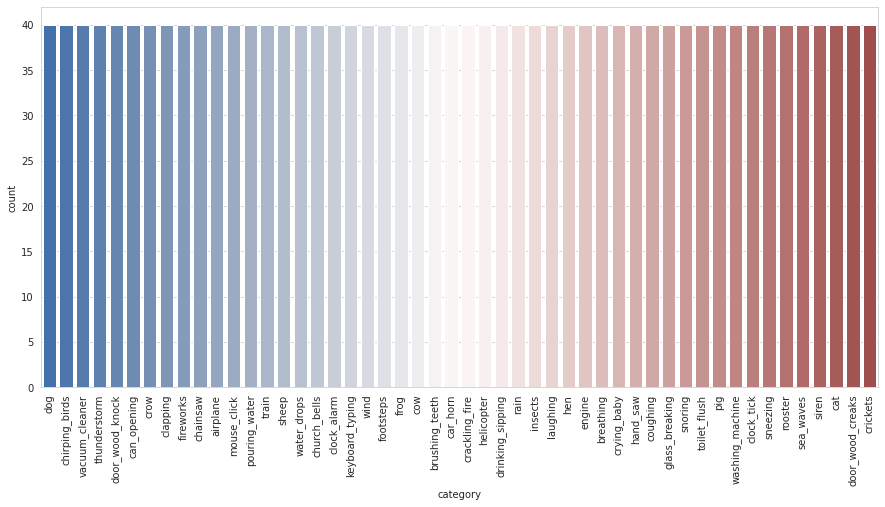

In [14]:
f, ax = plt.subplots()
sns.countplot(data=metadata, x='category', palette='vlag', ax=ax)
ax.tick_params(axis='x', rotation=90)

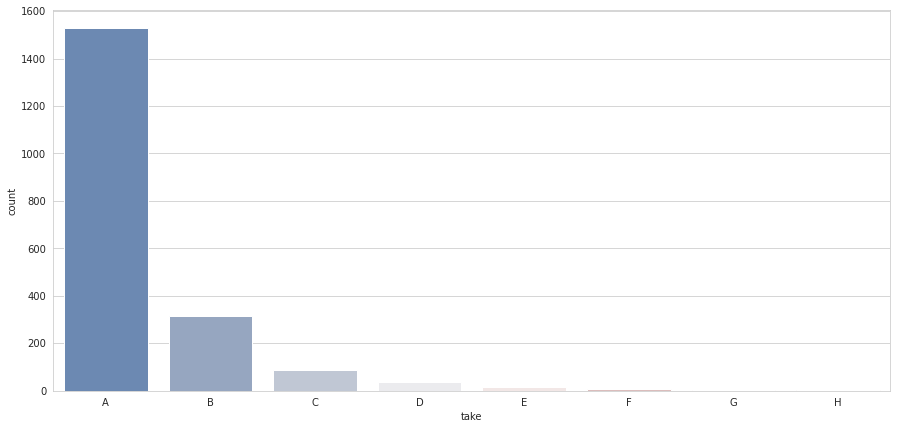

In [21]:
sns.countplot(data=metadata, x='take', palette='vlag')

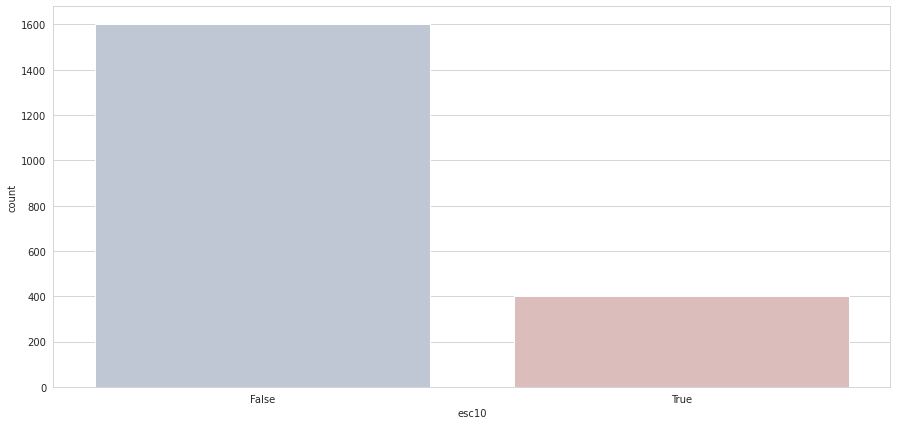

In [20]:
sns.countplot(data=metadata, x='esc10', palette='vlag')

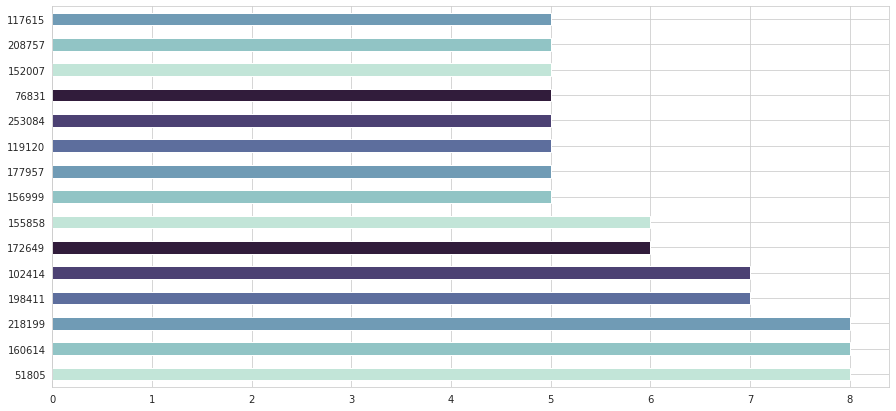

In [72]:
metadata['src_file'].value_counts().head(15).plot(kind='barh', color=palette)

#### Audio File

> sample rate (sampling rate) define how many times / second a sound is sampled. librosa also normalize audio in range 1 and -1

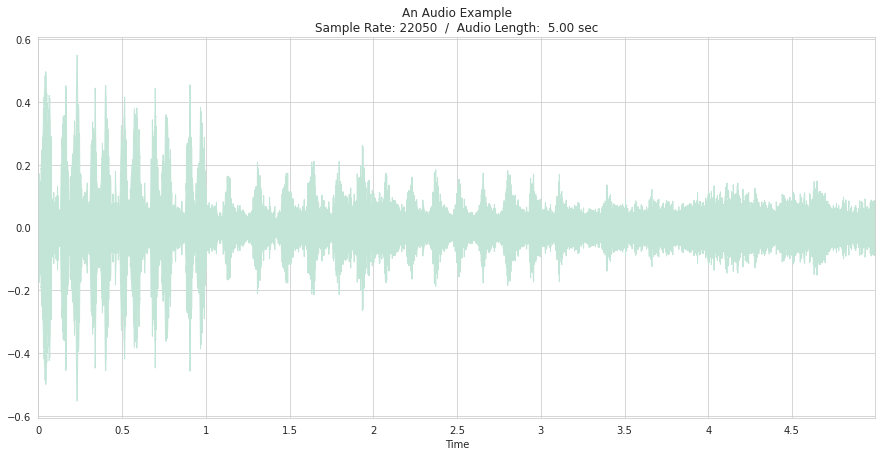

In [80]:
example_file = "/content/environmental-sound-classification-50/audio/audio/44100/1-100038-A-14.wav"
audio, sr = librosa.load(example_file)
ld.waveplot(audio, sr=sr)
plt.title(f"An Audio Example\nSample Rate: {sr}  /  Audio Length: {audio.shape[0]/sr: .2f} sec");
ipd.Audio(filename=example_file)

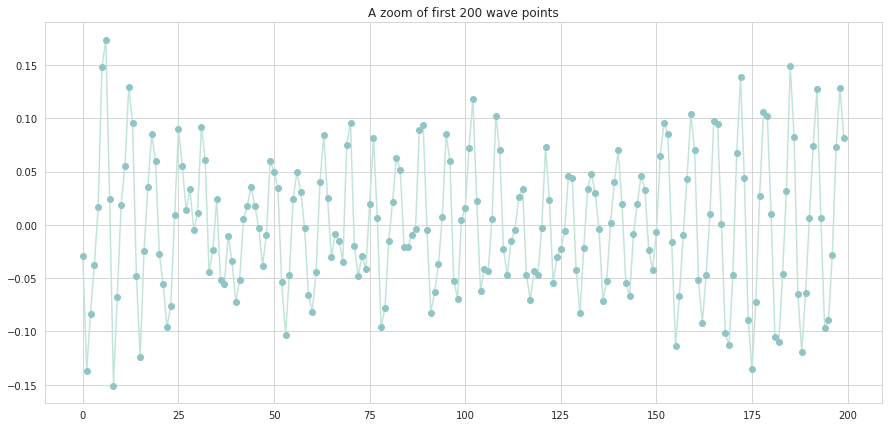

In [ ]:
plt.plot(audio[:200]); plt.plot(audio[:200], "o");
plt.title("A zoom of first 200 wave points");

#### Harmonics and Perceptrual
> - Harmonics are characteristichs that represent the sound color
- Perceptrual shock wave represents the sound rhythm and emotion

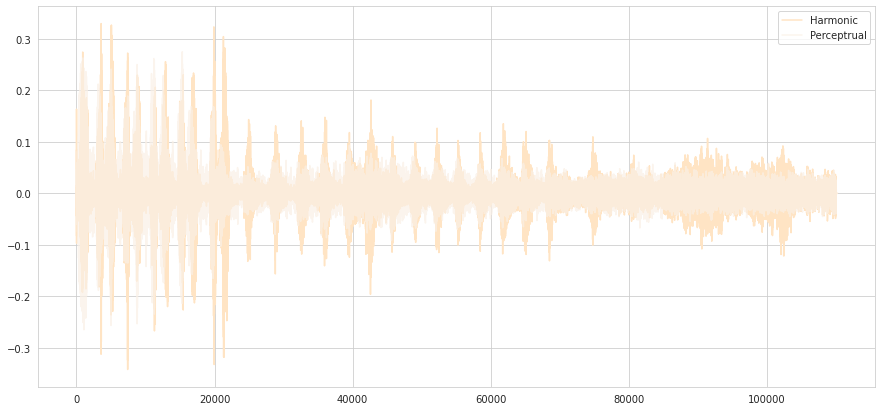

In [ ]:
harmony, perceptrual = librosa.effects.hpss(audio)
plt.plot(perceptrual, color = "bisque")
plt.plot(harmony, color = 'linen', alpha =.7)
plt.legend(['Harmonic', 'Perceptrual'])

#### Spectrum and Energy

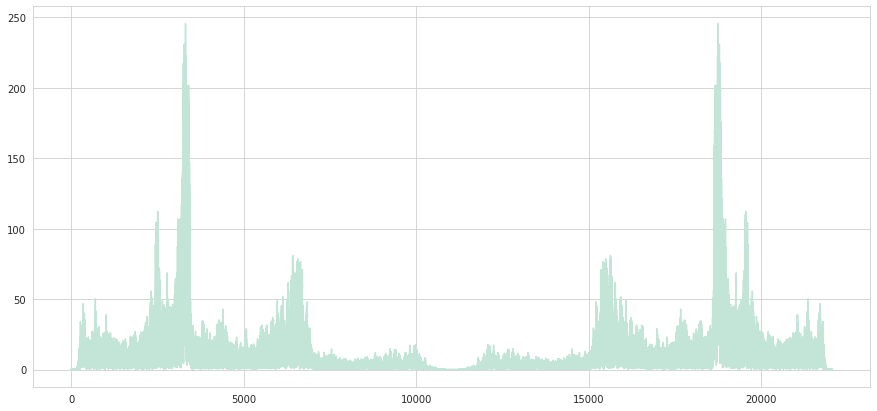

In [ ]:
fft = np.fft.fft(audio)
magnitude = np.abs(fft)
freq = np.linspace(0, sr, len(magnitude))
plt.plot(freq, magnitude)

### Feature Extraction

#### Extract all audio file

In [82]:
base_path = r"/content/environmental-sound-classification-50/audio/audio/"
dataset = metadata[['filename', 'category']].copy()
audios = []
for filename in dataset.filename.values:
  audio, _ = librosa.load(base_path+filename)
  audios.append(audio)

dataset['audio'] = pd.Series(audios)

In [90]:
idx = np.random.randint(len(dataset))
audio = dataset.loc[idx, "audio"]
sr = 22050
audio, sr

(array([-0.00637645, -0.0143234 , -0.02419745, ...,  0.0119774 ,
        -0.02473303, -0.06992064], dtype=float32), 22050)

#### Zero Crossing Rate
The zero crossing rate is the rate of sign-changes along a signal, i.e., the rate at which the signal changes from positive to negative or back

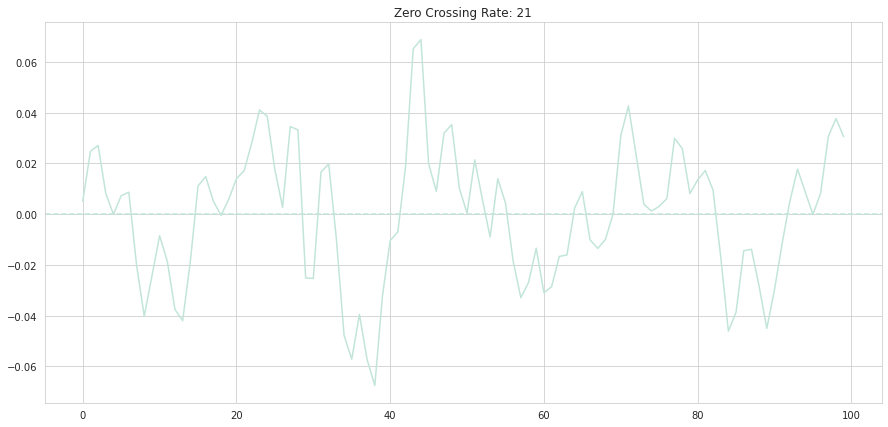

In [92]:
f, ax = plt.subplots()
ax.plot(audio[1000:1100])
ax.axhline(0, ls='--')
r = sum(librosa.zero_crossings(audio[1000:1100]))
plt.title(f"Zero Crossing Rate: {r}");

#### Spectral Centroid
> Show the location of "centre of mass" for a sound, calculated as the weighted mean of the frequencies present in the sound. 

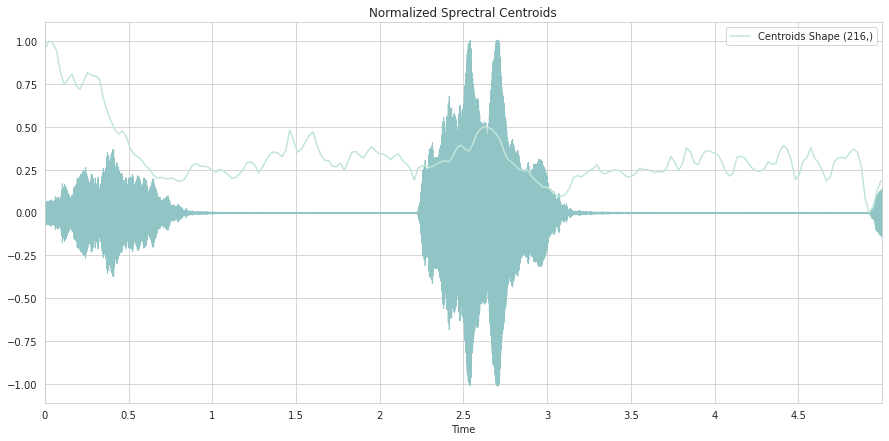

In [97]:
spectral_centroids = librosa.feature.spectral_centroid(audio, sr=sr)[0]
frames = range(len(spectral_centroids))
time  = librosa.frames_to_time(frames)

plt.plot(time, normalize(spectral_centroids))
plt.legend([f'Centroids Shape {spectral_centroids.shape}'])
ld.waveplot(audio)
plt.title("Normalized Sprectral Centroids");

#### Spectral Rolloff
> measure the shape of signal while represent the frequency below a certain percentage of total spectral energy (e.g. 85%)

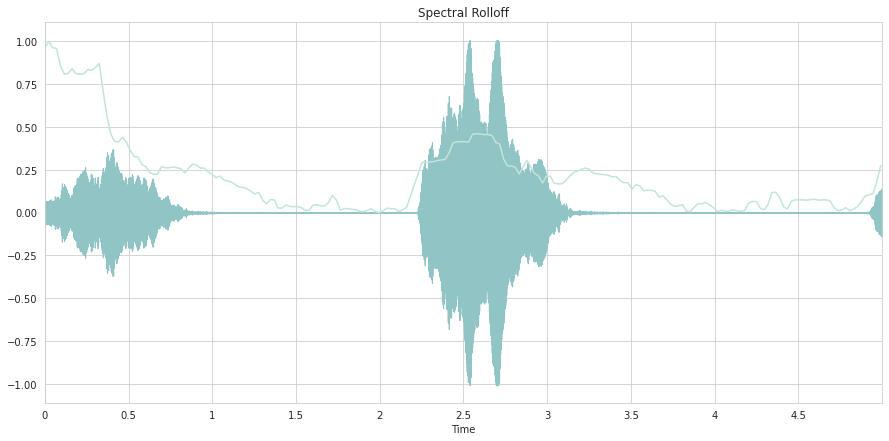

In [95]:
spectral_rolloff = librosa.feature.spectral_rolloff(audio+.01, sr=sr)[0]
plt.plot(time, normalize(spectral_rolloff))
ld.waveplot(audio)
plt.title("Spectral Rolloff");

#### Mel-Frequency Cepstral Coefficients (MFCCs)
> Small set of features that describe the overall sprect envelope shape and models the characteristics of the human voice.



/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


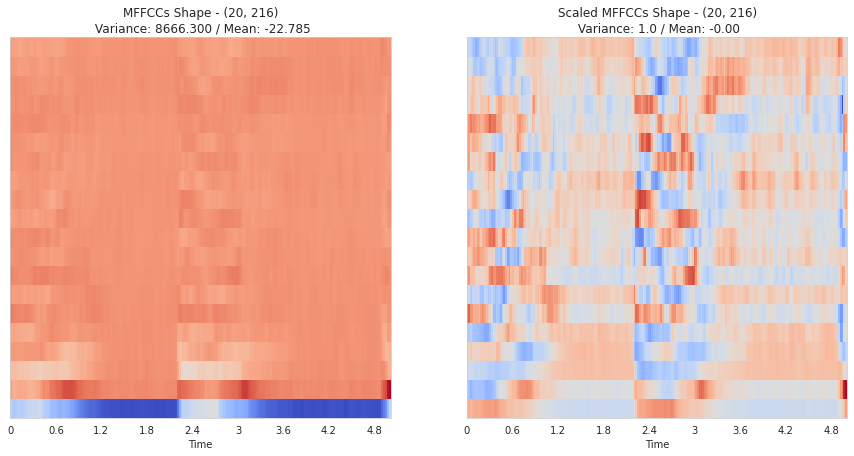

In [98]:
f, axes = plt.subplots(1, 2)

mfccs = librosa.feature.mfcc(audio, sr=sr)
ld.specshow(mfccs, sr=sr, x_axis='time', ax=axes[0])
axes[0].set_title(f'MFFCCs Shape - {mfccs.shape}\n Variance: {mfccs.var():.3f} / Mean: {mfccs.mean():.3f}');

scaled_mfccs = scale(mfccs, axis=1)
ld.specshow(scaled_mfccs, sr=sr, x_axis='time', ax=axes[1])
axes[1].set_title(f'Scaled MFFCCs Shape - {mfccs.shape}\n Variance: {scaled_mfccs.var()} / Mean: {scaled_mfccs.mean():.2f}');

#### Spectral Bandwidth
> width of the band at one-half width of the max intensity or full-width of half-max intensity(FWHM)

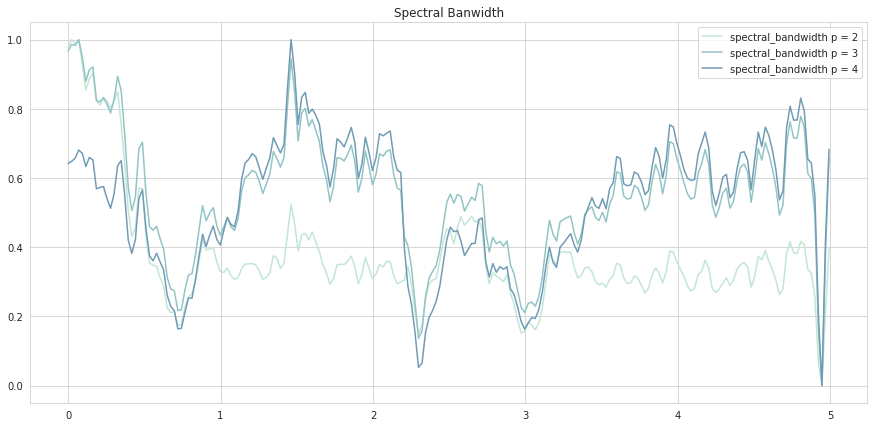

In [105]:
spectral_bandwidth2 = normalize(librosa.feature.spectral_bandwidth(audio+.01, sr=sr, p=2)[0])
spectral_bandwidth3 = normalize(librosa.feature.spectral_bandwidth(audio+.01, sr=sr, p=3)[0])
spectral_bandwidth4 = normalize(librosa.feature.spectral_bandwidth(audio+.01, sr=sr, p=4)[0])

plt.plot(time, spectral_bandwidth2); plt.plot(time, spectral_bandwidth3); plt.plot(time, spectral_bandwidth4);
plt.title("Spectral Banwidth")
plt.legend(["spectral_bandwidth p = 2", "spectral_bandwidth p = 3", "spectral_bandwidth p = 4"])

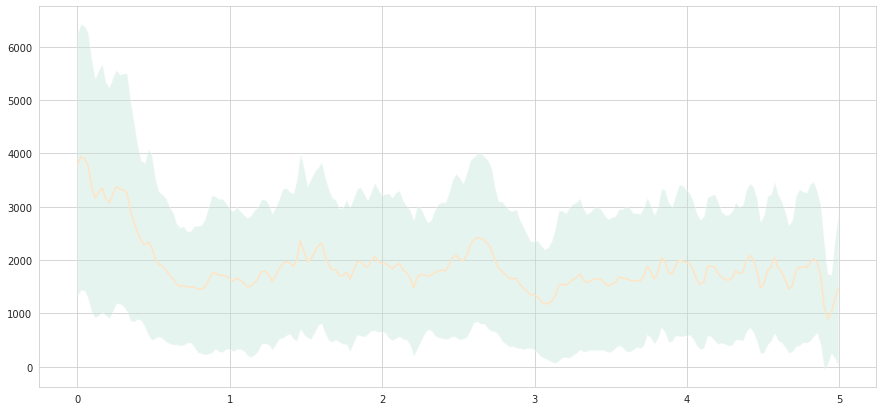

In [107]:
spectral_bandwidth = librosa.feature.spectral_bandwidth(audio+.01, sr=sr, p=2)[0]
f, ax = plt.subplots()
ax.plot(time, spectral_centroids, color='bisque')

lower_interval = spectral_centroids - spectral_bandwidth
higher_interval = spectral_centroids + spectral_bandwidth
ax.fill_between(time, higher_interval, lower_interval, label="Spectral Centroids Bandwidth Interval", alpha=.4)

#### Poly Features
> Get coefficients of fitting an nth-order polynomial to the columns of a spectrogram. 0, 1, 2 compute constant, linear and quadratic term respectively.

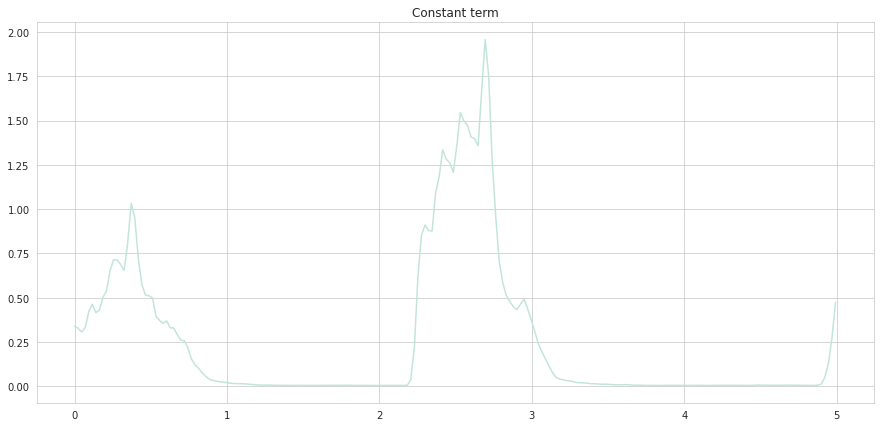

In [108]:
f, ax = plt.subplots()

stft = np.abs(librosa.stft(audio))
poly_features = librosa.feature.poly_features(S=stft, order=0)
times = librosa.times_like(poly_features)
ax.plot(times, poly_features[0], label="order 0")
ax.set_title("Constant term");

#### Spectrograms and Chromagrams
- Linear Spectrograms using [ Short-time Fourier transform (STFT) ](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to determine frequency and phase content of signal over time.
- MelSpectrogram: represents an acoustic time-frequency representation of a sound
- Chromagrams - different pitch classes
- Constant-Q plots can be decorated using either the frequencies (Hz) or their note names in scientific pitch notation

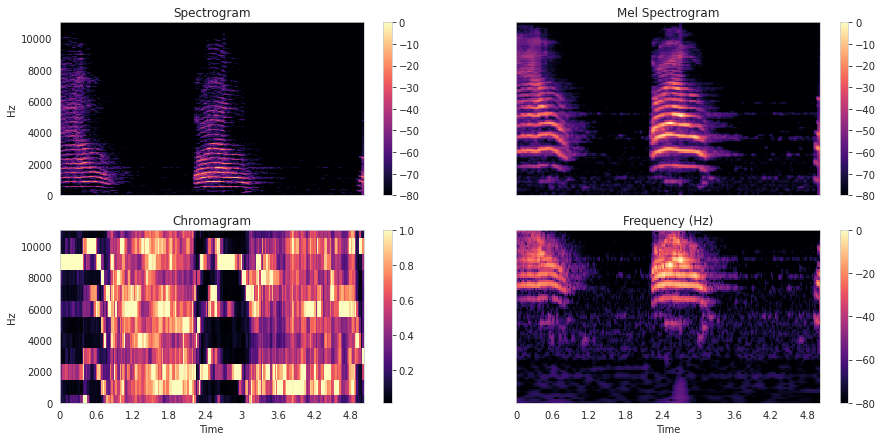

In [111]:
f, axes = plt.subplots(2, 2)

stft = np.abs(librosa.stft(audio))
db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
spec = ld.specshow(db, ax=axes[0, 0], x_axis='time', y_axis='linear');
axes[0, 0].set_title("Spectrogram");
f.colorbar(spec, ax=[axes[0, 0]]);

mel = librosa.feature.melspectrogram(audio, sr=sr)
m_dp = librosa.power_to_db(mel, ref=np.max)
melspec = ld.specshow(m_dp, ax=axes[0, 1], x_axis='time', y_axis='linear');
axes[0, 1].set_title("Mel Spectrogram");
f.colorbar(melspec, ax=[axes[0, 1]]);

chro_cqt = librosa.feature.chroma_cqt(audio, sr=sr)
chroma = ld.specshow(chro_cqt, ax=axes[1, 0], x_axis='time', y_axis='linear')
axes[1, 0].set_title("Chromagram");
f.colorbar(chroma, ax=[axes[1, 0]]);

cqt = librosa.cqt(audio, sr=sr)
cqt_db = librosa.amplitude_to_db(np.abs(cqt), ref=np.max)
cqt_spec = ld.specshow(cqt_db, ax=axes[1, 1], x_axis='time', y_axis='cqt_hz')
axes[1, 1].set_title('Frequency (Hz)')
f.colorbar(cqt_spec, ax=[axes[1, 1]]);

[[ax.label_outer() for ax in axe] for axe in axes];

#### Save data into `pickle file`

In [113]:
dataset.head()

,filename,category,audio
0,1-100032-A-0.wav,dog,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1-100038-A-14.wav,chirping_birds,"[-0.029419238, -0.13688716, -0.08337966, -0.03..."
2,1-100210-A-36.wav,vacuum_cleaner,"[-0.006616091, -0.011910033, -0.0030402767, -0..."
3,1-100210-B-36.wav,vacuum_cleaner,"[0.37941363, 0.29618832, 0.17503375, 0.7082076..."
4,1-101296-A-19.wav,thunderstorm,"[-0.0003722518, -0.00077188, 0.0002965101, 0.0..."


In [138]:
dataset.to_pickle("analyzed_esc50.pkl")

In [ ]:
# https://www.youtube.com/watch?v=mHPpCXqQd7Y
# https://www.kaggle.com/parulpandey/eda-and-audio-processing-with-python
# https://www.kaggle.com/andradaolteanu/birdcall-recognition-eda-and-audio-fe3.-The-Audio-Files%F0%9F%94%88%F0%9F%94%89%F0%9F%94%8A